## **Scripts used to download archives of climate data**

In [1]:
import xarray as xr
import os
import re
import glob
from IPython.display import clear_output

import sys; sys.path.append('/home/clair/wwa'); from wwa import decode_times

---
### **GMST from Climate Explorer**

In [ ]:
! curl http://climexp.knmi.nl/getindices.cgi?STATION=smoothed_GMST&TYPE=i&WMO=NASAData/giss_al_gl_a_4yrlo&id=62f4b5a82fde776a4c64f0ca33646aa0 --output /home/clair/wwa/90_data/gmst.dat

# curl fails - check & resolve (also for Nino3.4?)


---
### **CHIRPS**

Download archive of global daily data at 0.25 / .05 degree resolution:
```
! cd /home/clair/Data/chirps_25; for y in `seq 1981 2022`; do wget https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/chirps-v2.0.$y.days_p25.nc; done
! cd /home/clair/Data/chirps_05; for y in `seq 1981 2022`; do wget https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/chirps-v2.0.$y.days_p05.nc; done
```

Update with latest file only:
```
! cd /home/clair/Data/chirps_25; wget https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/chirps-v2.0.2023.days_p25.nc
! cd /home/clair/Data/chirps_05; wget https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/chirps-v2.0.2023.days_p05.nc
```

In [2]:
# ! cd /home/clair/Data/chirps_25; rm chirps-v2.0.2023.days_p25.nc; wget https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/chirps-v2.0.2023.days_p25.nc
! cd /home/clair/Data/chirps_05; rm chirps-v2.0.2023.days_p05.nc; wget https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/chirps-v2.0.2023.days_p05.nc

--2023-03-06 12:04:30--  https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/chirps-v2.0.2023.days_p05.nc
Resolving data.chc.ucsb.edu (data.chc.ucsb.edu)... 128.111.100.31
Connecting to data.chc.ucsb.edu (data.chc.ucsb.edu)|128.111.100.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105993611 (101M) [application/x-netcdf]
Saving to: ‘chirps-v2.0.2023.days_p05.nc’

chirps-v2.0.2023.da 100%[===================>] 101.08M  2.38MB/s    in 53s     

2023-03-06 12:05:24 (1.90 MB/s) - ‘chirps-v2.0.2023.days_p05.nc’ saved [105993611/105993611]



---
### **E-OBS**

In [ ]:
# define variables to download
var_list = ["tg", "tn", "tx", "rr"]
os.chdir("/home/clair/Data/e-obs_025/")

#### Download archive of data at 0.25 degree resolution 
- only needs to be modified / run when version updated

In [ ]:
chunks = ["1950-1964", "1965-1979", "1980-1994", "1995-2010"]
for varnm in var_list:
    for ch in chunks:

        urlstring = "https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.25deg_reg_ensemble/"+varnm+"_ens_mean_0.25deg_reg_"+ch+"_v26.0e.nc"
        ! wget $urlstring
        
    clear_output(wait = False)
    
print("Done.")

#### Download & merge current data

- get most recent chunk + current calendar year + last 60 days
- concatenate latest data into a single file

In [ ]:
# method adapted from https://developer.dataplatform.knmi.nl/example-scripts#list-10-current-files-get-first

import requests

def download_file_from_temporary_download_url(download_url, filename):
    # support method to download individual files from URL
    try:
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            with open(filename, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    except Exception:
        print("Unable to download file using download URL")
        
    print(filename+" downloaded")

def download_eobs_60day(varnm):
    
    # method to list all available files & download

    api_url = "https://api.dataplatform.knmi.nl/open-data/v1/datasets/daily_updated_"+varnm+"_eobs/versions/1/files"
    
    list_files = requests.get(f"{api_url}", headers = {"Authorization": api_key}, params = {"maxKeys": 200}).json().get("files")
    list_files = [file for file in list_files if "0.25deg" in file.get("filename")]
    
    for file in list_files:
        
        filename = file.get("filename")
        endpoint = f"{api_url}/{filename}/url"
        get_file_response = requests.get(endpoint, headers={"Authorization": api_key})
        
        download_url = get_file_response.json().get("temporaryDownloadUrl")
        download_file_from_temporary_download_url(download_url, filename)
        
    clear_output(wait = False)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# load API from file - https://developer.dataplatform.knmi.nl/get-started#obtain-an-api-key
with open("/home/clair/Data/knmi_api.txt") as f_api: api_key = f_api.read()



In [ ]:
os.chdir("/home/clair/Data/e-obs_025/tmp")

for varnm in var_list:
    
    # download current chunk
    chunk_string = "https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/Grid_0.25deg_reg_ensemble/"+varnm+"_ens_mean_0.25deg_reg_2011-2022_v26.0e.nc"
    if os.path.exists(re.sub(".+/", "", chunk_string)): 
        print("Delete existing "+varnm+" files manually first")
        continue
    ! wget $chunk_string
        
    # download current calendar year
    cy_string = "https://knmi-ecad-assets-prd.s3.amazonaws.com/ensembles/data/months/ens/"+varnm+"_0.25deg_day_2022_grid_ensmean.nc"
    ! wget $cy_string
    
    # download last 60 days
    download_eobs_60day(varnm)
    
    # load the latest data for this year
    ds_chunk = xr.open_dataset(re.sub(".+/", "", chunk_string)).dropna("time", "all")
    ds_cy = xr.open_dataset(re.sub(".+/", "", cy_string)).dropna("time", "all")
    ds_60d = xr.open_mfdataset([fnm for fnm in glob.glob(varnm+"*.nc") if re.search("_[0-9]{8}_", fnm)])
    
    # use latest version of each day available (60d > monthly current year > most recent chunk)
    ds_cy = ds_cy.sel(time = ds_cy.time < ds_60d.time.min())
    ds_chunk = ds_chunk.sel(time = ds_chunk.time < ds_cy.time.min())
    
    # save as netcdf
    ds_latest = xr.concat([ds_chunk, ds_cy, ds_60d], "time")
    ds_latest.to_netcdf("../"+re.sub(".+/", "", re.sub("[0-9]{4}-[0-9]{4}", "latest", chunk_string)))
    
    clear_output(wait = False)
    print("Done.")

---
### **CPC**

Download archive of global daily precip, tmax, tmin
```
! cd /home/clair/Data/cpc; for y in `seq 1979 2023`; do wget https://downloads.psl.noaa.gov/Datasets/cpc_global_precip/precip.$y.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmax.$y.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmin.$y.nc; done
```

Update with latest data:
```
! cd /home/clair/Data/cpc; rm precip.2023.nc; rm tmax.2023.nc; rm tmin.2023.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_precip/precip.2023.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmax.2023.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmin.2023.nc
```

In [ ]:
! cd /home/clair/Data/cpc; rm precip.2023.nc; rm tmax.2023.nc; rm tmin.2023.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_precip/precip.2023.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmax.2023.nc; wget https://downloads.psl.noaa.gov/Datasets/cpc_global_temp/tmin.2023.nc

### **MSWEP**

Download & setup instructions [here](http://www.gloh2o.org/mswep/#faq)

To update with latest near-real-time data:

```
rclone sync -v --drive-shared-with-me googledrive:/MSWEP_V280/NRT/Daily /home/clair/Data/mswep_nrt
rclone sync -v --drive-shared-with-me googledrive:/MSWEP_V280/Past/Daily /home/clair/Data/mswep_past
rclone sync -v --drive-shared-with-me googledrive:/MSWEP_V280/NRT/3hourly /home/clair/Data/mswep_3hr
```

---
## **Climate indices**

### **Smoothed GMST**
- GMSTs downloaded from Climate Explorer


#### **CMIP5**

In [189]:
# dictionary to convert between CMIP5 ensemble member id assigned by Climate Explorer and GCM
# NB. This is specific to the files already downloaded & will need to be checked if they are ever updated, since the numbering may change
cmip5_mdl = {"004" : "CanESM2_r1",
             "021" : "CNRM-CM5_r1",
             "026" : "CSIRO-Mk3-6-0_r1",
             "038" : "EC-EARTH_r1",
             "040" : "EC-EARTH_r3",
             "036" : "EC-EARTH_r12",
             "049" : "GFDL-ESM2M_rcp85_r1",
             "058" : "HadGEM2-ES_r1",
             "063" : "IPSL-CM5A-LR_r1",
             "067" : "IPSL-CM5A-MR_r1",
             "069" : "MIROC5_r1",
             "074" : "MPI-ESM-LR_r1",
             "075" : "MPI-ESM-LR_r2",
             "076" : "MPI-ESM-LR_r3",
             "077" : "MPI-ESM-MR_r1",
             "080" : "NorESM1-M_r1"}

for fnm in sorted(glob.glob("00_gsat/iiglobal_tas_Amon_ens_rcp85*.nc")):
    
    ens_num = fnm[-6:-3]
    gmst = convert_units_to(decode_times(xr.open_dataset(fnm, decode_times = False).tas.isel(time = slice(0,3500))), "degC")
    mdl = gmst.long_name.split(" ")[1]+"_rcp85_"+gmst.long_name.split(" ")[-1]
    
    # verify that correct time series is being used
    if not re.sub("i1p1", "", re.sub("_rcp85", "", mdl)) == cmip5_mdl[str(ens_num)]:
        print("Check:", ens_num, cmip5_mdl[str(ens_num)], gmst.long_name)
    
    ts = gmst.resample(time = "AS-JAN").mean().rolling(time = 4, center = True).mean().dropna("time", "any")   # annual GMST, 4-year rolling average
    ts = ts - ts.sel(time = "2022").values                                                                     # anomaly wrt 2022
    
    csv_fnm = "00_gsat/cmip5_smoothed-gsat_"+"_rcp85_".join(cmip5_mdl[ens_num].split("_"))+".dat"
    csv_fnm = re.sub("rcp85_rcp85_rcp85", "rcp85", csv_fnm)
    if len(csv_fnm.split("/")[-1]) >= 65: print("! Filename too long: ", csv_fnm)
    
    # create  header lines
    str1 = "# contact :: CMIP5-"+ens_num+" "+mdl+" smoothed GSAT anomaly - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# gmst [degC] 4-year smoothed global surface air temperature anomaly wrt 2022 at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year gmst"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    ts.assign_coords(time = ts.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

Check: 040 EC-EARTH_r3 from EC-Earth 2.3 experiment for CMIP5 RCP8.5
Check: 049 GFDL-ESM2M_rcp85_r1 from NOAA GFDL GFDL-ESM2M, RCP8.5 (run 1) experiment output for CMIP5 AR5 r1i1p1


<AxesSubplot: xlabel='year'>

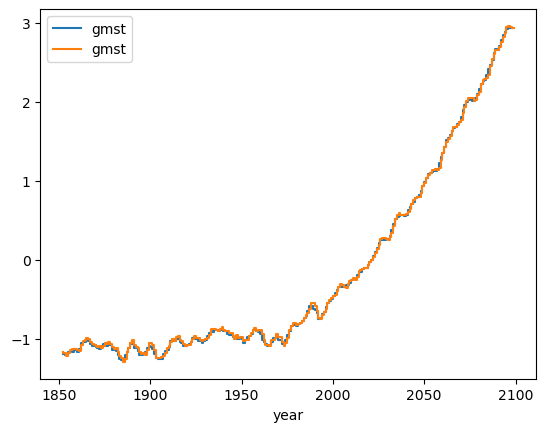

In [133]:
# quick visual check against previous version
pd.read_csv("00_gsat/cordex_tas_Amon_NorESM1-M_rcp85_r1i1p1.dat", comment = "#", sep = " ", header = None, names = ["year", "gmst"], index_col = 0).plot(drawstyle = "steps")
pd.read_csv(csv_fnm, comment = "#", sep = " ", header = None, names = ["year", "gmst"], index_col = 0).plot(drawstyle = "steps", ax = plt.gca())

### **Nino3.4 & detrended Nino3.4**
- detrend Nino3.4 by subtracting tropical SSTs (per paper reference in Climate Explorer, but without normalising per calendar month)
- Nino3.4 and tropical SSTs obtained from Climate Explorer


#### **Observed**

In [1]:
nino = decode_times(xr.open_dataset("../Data/iersst_nino3.4a.nc", decode_times = False))["Nino3.4"].sel(time = slice("1950", None))
sst = decode_times(xr.open_dataset("../Data/iersstv5_0-360E_-20-20N_n_su.nc", decode_times = False)).sst.sel(time = slice("1950", None))
nino_detrended = nino - (sst - sst.mean())

#### **CMIP5**

In [191]:
cmip5_mdl = {"004" : "CanESM2_r1",
             "020" : "CNRM-CM5_r1",
             "025" : "CSIRO-Mk3-6-0_r1",
             "035" : "EC-EARTH_r1",
             "037" : "EC-EARTH_r3",
             "041" : "EC-EARTH_r12",
             "049" : "GFDL-ESM2M_rcp85_r1",
             "058" : "HadGEM2-ES_r1",
             "063" : "IPSL-CM5A-LR_r1",
             "067" : "IPSL-CM5A-MR_r1",
             "069" : "MIROC5_r1",
             "074" : "MPI-ESM-LR_r1",
             "075" : "MPI-ESM-LR_r2",
             "076" : "MPI-ESM-LR_r3",
             "077" : "MPI-ESM-MR_r1",
             "079" : "NorESM1-M_r1"}

for fnm in glob.glob("10_nino-detrended/*-5-5N*.nc"):
    
    ens_num = fnm[-6:-3]
    ds = decode_times(xr.open_dataset(fnm, decode_times = False))
    nino = ds.tas
    tsst_ds = decode_times(xr.open_dataset(re.sub("iicmip", "icmip", re.sub("-120--170E_-5-5N", "0-360E_-20-20N", fnm)), decode_times = False))
    tsst = tsst_ds.tas
    nino_dt = nino-tsst
    mdl = ds.title.split(" ")[3]+"_rcp85_"+ds.title.split(" ")[-1]
    
    # verify that correct time series is being used
    if not re.sub("i1p1", "", re.sub("_rcp85", "", mdl)) == cmip5_mdl[str(ens_num)]:
        print("Check:", ens_num, cmip5_mdl[str(ens_num)], ds.title)
    
    # make sure the Nino & SST time series match
    if not ds.title == tsst_ds.title:
        print("Check:", ds.title,"/",tsst_ds.title)
    
    csv_fnm = "10_nino-detrended/cmip5_nino-detrended_"+"_rcp85_".join(cmip5_mdl[ens_num].split("_"))+".dat"
    csv_fnm = re.sub("rcp85_rcp85_rcp85", "rcp85", csv_fnm)
    if len(csv_fnm.split("/")[-1]) >= 65: print("! Filename too long: ", csv_fnm)
    
    # create  header lines
    str1 = "# contact :: CMIP5-"+fnm[-6:-3]+" "+mdl+" detrended Nino3.4 index - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# nino34_dt [degC] difference between SSTs averaged over (120W-170W, 5S-5N) & (20S-20N) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# date nino34_dt"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    nino_dt.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

Check: 037 EC-EARTH_r3 spatial statistic of EC-Earth 2.3 experiment for CMIP5 RCP8.5
Check: 049 GFDL-ESM2M_rcp85_r1 spatial statistic of NOAA GFDL GFDL-ESM2M, RCP8.5 (run 1) experiment output for CMIP5 AR5 r1i1p1
